In [ ]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ================================
# Kalman Filter
# ================================
class KF:
    def __init__(self, x0, P0, Q, R):
        self.x = x0; self.P = P0; self.Q = Q; self.R = R
    def predict(self): self.P += self.Q
    def update(self, z):
        K = self.P/(self.P+self.R)
        self.x = self.x + K*(z-self.x)
        self.P = (1-K)*self.P
        return self.x

def simulate_vehicle_speed(vehicle,mass, current_speed, throttle_input, braking_input, delta_time):
    # Constants and vehicle parameters (simplified)
    C_drag = 0.3  # Drag coefficient
    A_frontal = 2.0  # Frontal area (m^2)
    rho_air = 1.225  # Air density (kg/m^3)
    C_rolling = 0.01 # Rolling resistance coefficient
    max_engine_force = 5000 # Maximum available engine force (Newtons) - depends on gear/torque curve

    # Calculate forces
    # 1. Tractive Force (simplified from throttle input)
    # A realistic model would use engine torque curves and gear ratios
    tractive_force = max_engine_force * throttle_input

    # 2. Aerodynamic Drag Force (proportional to velocity squared)
    drag_force = 0.5 * rho_air * current_speed**2 * C_drag * A_frontal

    # 3. Rolling Resistance Force (simplified, can be considered constant at low speeds)
    rolling_resistance_force = mass * 9.81 * C_rolling # mass * gravity * coefficient

    # 4. Braking Force (simplified from braking input)
    braking_force = 10000 * braking_input # Max braking force (Newtons)

    # Net Force
    net_force = tractive_force - drag_force - rolling_resistance_force - braking_force

    # Acceleration (a = F / m)
    acceleration = net_force / mass


    if (braking_input > 0):
        acceleration = -a
        #print(f"Breaking for {vehicle} requested: current_speed:{current_speed}, braking_input:{braking_input} new_speed {new_speed} current_speed {current_speed}, acceleration {acceleration}")

        # Update Speed (using simple Euler integration)
        # New velocity = Old velocity + acceleration * time step
    new_speed = current_speed + (acceleration * delta_time)

    # Speed cannot be negative
    if new_speed < 0:
        new_speed = 0

    return new_speed, acceleration


##  Simulate the speed of the vehicle
##
def get_vehicle_speed(vehicle, current_speed, throttle, braking, time_step, faultinjection):
    if (current_speed >= 90):
        braking = 1
    else:
        braking = round(random.betavariate(0.4,1))
        throttle = random.random()*4

    # The maximum throttle is 1
    if (throttle > 1.0):
        throttle = 1.0

    current_speed, acc = simulate_vehicle_speed(vehicle,1200, current_speed, throttle, braking, time_step)

#        if (tcurrent_speed <= 90):
#            current_speed, acc = tcurrent_speed, tacc

    #print(f"{vehicle} Speed: {current_speed:.2f} m/s, brak {braking:.2f} thro {throttle:.2f} Acceleration: {acc:.2f} m/s^2")
    return current_speed, braking

    # End

# Compute teh safe distance

def get_safe_distance(current_speed):

    distance = (Speed_conversion * h * current_speed) + ((0.039 * math.sqrt(current_speed))/a)
    return distance

# Compute GAP distance between the two vehicle
def get_Gapdistance(previous_distance, host_speed, lead_speed):
    distance = previous_distance + ((lead_speed - host_speed) * time_step)
    return distance

# -------------------------------
# Lemma 4.1 Equation (Eq. 24)
# -------------------------------

def compute_v_thr(d, v_l, u, h, dt):
    """
    Compute v_thr at step k+1 given:
    - d_hat_k     : estimated gap d_k
    - v_l_hat_k   : estimated lead speed v_l,k
    - u           : deceleration parameter
    - h           : headway time
    - dt          : sampling time Δt
    """
    b = Speed_conversion * h + dt
    inside = (b**2) + ((0.156 / u) * (d + (v_l * dt)))
    if (inside < 0):
        inside (f"inside {inside:.2f} d_hat_k {d:.2f}, dt {dt:.2f}, v_l:{v_l:.2f}, h:{h}, a:{a}")
    #    v_thr = 0
    else:
        v_thr = (u / 0.078) * (-b + np.sqrt(inside))

    return v_thr

def v_threshold(d, dt, v_l, h, a):
    term1 = 0.278 * h + dt
    term2 = term1**2 + (0.156 / a) * (d + v_l * dt)
    if (term2 < 0):
        print (f"term 2 {term2:.2f} d {d:.2f}, dt {dt:.2f}, v_l:{v_l:.2f}, h:{h}, a:{a}")

    return (a / 0.078) * (-term1 + np.sqrt(term2))

# -------------------------------
# Lemma 4.2 Equation (Eq. )
# -------------------------------
def compute_z_threshold(v_h_pred_k1, K_k1, d_hat_k, v_l_hat_k, u, h, dt):
    """
    Compute the threshold on the measurement z_{k+1} (measured host speed)
    such that the updated Kalman-filter estimate v_h(t+1|t+1) exceeds v_thr.

    Inputs:
    - v_h_pred_k1 : predicted host speed  v_h(t+1 | t)
    - K_k1        : Kalman gain at time k+1 (scalar, for speed update)
    - d_hat_k     : estimated gap d_k at time k
    - v_l_hat_k   : estimated lead speed v_l,k at time k
    - u           : deceleration parameter
    - h           : headway time
    - dt          : sampling time Δt

    Returns:
    - z_thr_k1    : minimum measurement z_{k+1} such that v_h(t+1|t+1) > v_thr
    """
    # 1) Compute threshold speed v_thr at k+1
    v_thr_k1 = compute_v_thr(d_hat_k, v_l_hat_k, u, h, dt)

    # 2) Compute measurement threshold z_{k+1}
    #    z_thr = [v_thr - (1 - K)*v_pred] / K
    z_thr_k1 = (v_thr_k1 - (1.0 - K_k1) * v_h_pred_k1) / K_k1

    return z_thr_k1


    # Example Usage:
# mass_of_car = 1200 kg, initial_speed = 0 m/s, time_step = 0.01 seconds
Hostcurrent_speed = 20.0
Leadcurrent_speed = 30.0
time_step = 0.01
throttle = 1.0 # Full throttle
braking = 0.0
h=2.0 #
a=3.4
Speed_conversion = 0.278 # Constant to convert speed from km/h to m/s

SimulationData=[]

kf = KF(Hostcurrent_speed, 10, 0.01, 0.1)

#Set the initial distance between the two vehicle to be the safe distance
safe_Distance = get_safe_distance(Hostcurrent_speed)
gap_distance=1.1 * safe_Distance

ntimes =0
rtimes =0

for j in range(1000): # Run for 10 seconds (1000 steps of 0.01s)
    faultinjection = 0

    Hostcurrent_speed, braking = get_vehicle_speed("Host", Hostcurrent_speed, throttle, braking, time_step, faultinjection)
    #kf.predict()
    #kf.update(Hostcurrent_speed)


    Leadcurrent_speed, lbrake = get_vehicle_speed("Lead",Leadcurrent_speed, throttle, 0, time_step, faultinjection)

    safe_Distance = get_safe_distance(Hostcurrent_speed)
    gap_distance = get_Gapdistance(gap_distance, Hostcurrent_speed, Leadcurrent_speed)

    #threshold_speed = compute_v_thr(gap_distance, Leadcurrent_speed, a, h, time_step)

    threshold_speed = v_threshold(gap_distance,time_step, Leadcurrent_speed,h,a)

    ## Decide on the next speed
    if (gap_distance < safe_Distance):
        Crash = 1
        ntimes= ntimes+1

    else:
        Crash = 0

    if (Hostcurrent_speed > threshold_speed):
        speedRisk = 1
        rtimes= rtimes+1
    else:
        speedRisk = 0

    SimulationData.append([Hostcurrent_speed,Leadcurrent_speed,threshold_speed,safe_Distance,gap_distance,braking,Crash,speedRisk])

    #print(f"{j} - Hostcurrent_speed:{Hostcurrent_speed:.2f}, Leadcurrent_speed {Leadcurrent_speed:.2f}, threshold_speed:{threshold_speed:.2f}, safe distance {safe_Distance:.2f}, gap_distance:{gap_distance:.2f}, Distance risk:{Crash}, speedRisk:{speedRisk}")

print(f"Safe distance is violated {ntimes} times")
print(f"Threshold speed is violated {rtimes} times")

for item in SimulationData:
    print(f"Record: {item}")


Safe distance is violated 0 times
Threshold speed is violated 47 times
Record: [19.966, 30.02193408154129, np.float64(16.739990635026217), 11.152350408199313, 12.388987173894675, 1, 0, 1]
Record: [20.005464828126417, 30.059859466347092, np.float64(16.84608575455146), 11.174343482404602, 12.489531120276881, 0, 0, 1]
Record: [20.04492482526018, 30.025859466347093, np.float64(16.95038789549549), 11.196333814475263, 12.58934046668775, 0, 0, 1]
Record: [20.08437998245489, 29.991859466347094, np.float64(17.053661951283193), 11.218321399591233, 12.688415261526671, 0, 0, 1]
Record: [20.123830290768765, 29.957859466347095, np.float64(17.155915587579557), 11.240306232934225, 12.786755553282454, 0, 0, 1]
Record: [20.16327574126462, 29.995796620898357, np.float64(17.25865202505718), 11.262288309687744, 12.885080762078791, 0, 0, 1]
Record: [20.16490883435494, 29.961796620898358, np.float64(17.360021796961515), 11.263198395268219, 12.983049639944225, 0, 0, 1]
Record: [20.16513044888148, 29.927796620

In [ ]:
# ============================================
# SAVE SIMULATION DATA TO GOOGLE DRIVE (CSV)
# ============================================

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Convert SimulationData list to DataFrame
sim_df = pd.DataFrame(
    SimulationData,
    columns=[
        "ego_vehicle_v_mps",      # Host speed (m/s)
        "leader_vehicle_v_mps",   # Lead speed (m/s)
        "threshold_speed",
        "safe_distance",
        "gap_distance",
        "braking",
        "distance_violation",     # 1 = gap < safe distance
        "speed_violation"         # 1 = v_h > v_thr
    ]
)

# Create timestamp column
sim_df["timestamp"] = np.arange(len(sim_df)) * time_step

# Reorder columns (timestamp first like real datasets)
sim_df = sim_df[[
    "timestamp",
    "ego_vehicle_v_mps",
    "leader_vehicle_v_mps",
    "threshold_speed",
    "safe_distance",
    "gap_distance",
    "braking",
    "distance_violation",
    "speed_violation"
]]

# Save to Google Drive
output_path = "/content/drive/MyDrive/simulated_acc_dataset.csv"
sim_df.to_csv(output_path, index=False)

print("Simulation dataset successfully saved at:")
print(output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Loaded Successfully!
   timestamp  ego_vehicle_v_mps  leader_vehicle_v_mps  threshold_speed  \
0       0.00          19.966000             30.021934        16.739991   
1       0.01          20.005465             30.059859        16.846086   
2       0.02          20.044925             30.025859        16.950388   
3       0.03          20.084380             29.991859        17.053662   
4       0.04          20.123830             29.957859        17.155916   

   safe_distance  gap_distance  braking  distance_violation  speed_violation  
0      11.152350     12.388987        1                   0                1  
1      11.174343     12.489531        0                   0                1  
2      11.196334     12.589340        0                   0                1  
3      11.218321     12.688415        0                   0                1  
4 

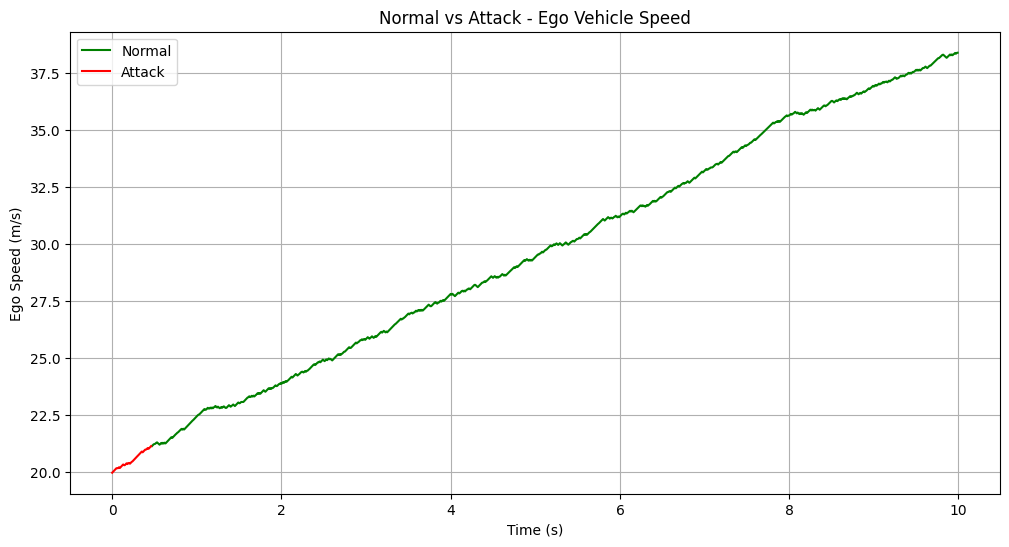

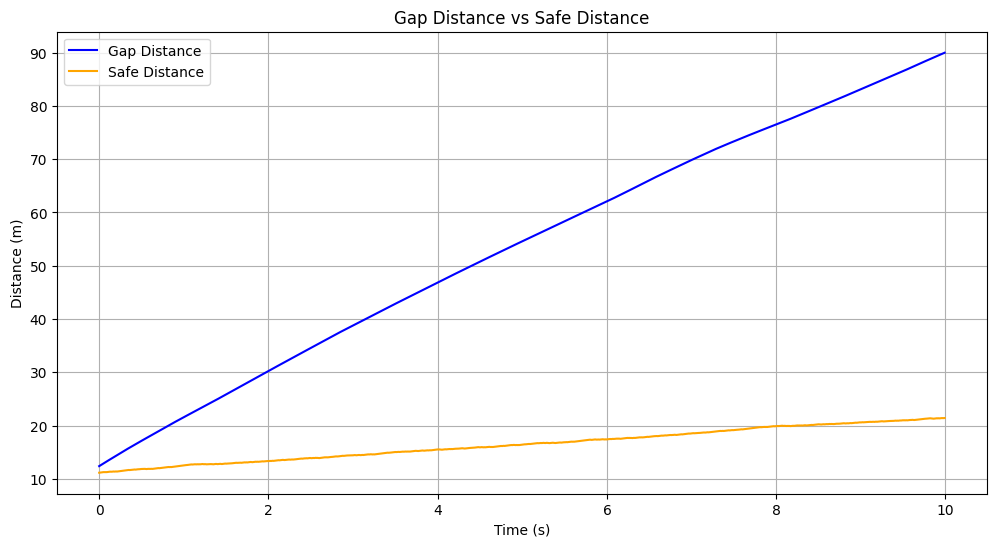

Plots generated successfully!


In [ ]:
# ============= STEP-1: Connect Google Drive =================
from google.colab import drive
drive.mount("/content/drive")

# ============= STEP-2: Load Dataset =========================
import pandas as pd

path = "/content/drive/MyDrive/simulated_acc_dataset.csv"
df = pd.read_csv(path)

print("Dataset Loaded Successfully!")
print(df.head())

# ============= STEP-3: Prepare Data =========================
df = df.sort_values(by="timestamp")

normal = df[df["speed_violation"] == 0]
attack = df[df["speed_violation"] == 1]

# ============= STEP-4: Plot Speed Normal vs Attack ==========
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(normal["timestamp"], normal["ego_vehicle_v_mps"],
         label="Normal", color="green")
plt.plot(attack["timestamp"], attack["ego_vehicle_v_mps"],
         label="Attack", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Ego Speed (m/s)")
plt.title("Normal vs Attack - Ego Vehicle Speed")
plt.legend()
plt.grid(True)
plt.show()

# ============= STEP-5: Distance vs Safe Distance ============
plt.figure(figsize=(12,6))
plt.plot(df["timestamp"], df["gap_distance"],
         label="Gap Distance", color="blue")
plt.plot(df["timestamp"], df["safe_distance"],
         label="Safe Distance", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Gap Distance vs Safe Distance")
plt.legend()
plt.grid(True)
plt.show()

print("Plots generated successfully!")


Mounted at /content/drive
Dataset Loaded From: /content/drive/MyDrive/simulated_acc_dataset.csv
   timestamp  ego_vehicle_v_mps  leader_vehicle_v_mps  threshold_speed  \
0       0.00          19.966000             30.021934        16.739991   
1       0.01          20.005465             30.059859        16.846086   
2       0.02          20.044925             30.025859        16.950388   
3       0.03          20.084380             29.991859        17.053662   
4       0.04          20.123830             29.957859        17.155916   

   safe_distance  gap_distance  braking  distance_violation  speed_violation  
0      11.152350     12.388987        1                   0                1  
1      11.174343     12.489531        0                   0                1  
2      11.196334     12.589340        0                   0                1  
3      11.218321     12.688415        0                   0                1  
4      11.240306     12.786756        0                   0     

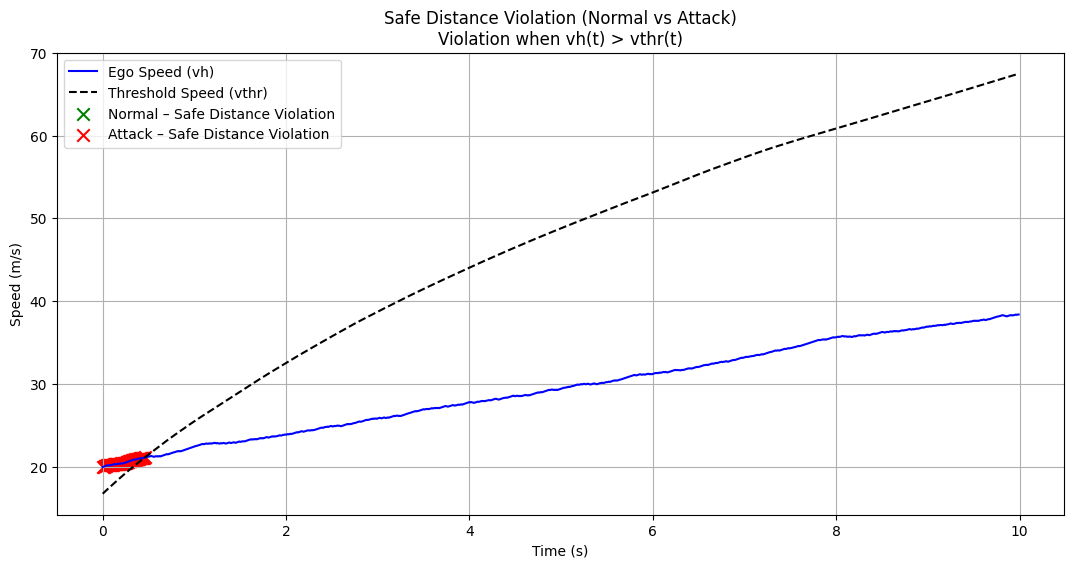

Plot generated successfully!


In [ ]:
# ================= STEP-1: Mount Google Drive =================
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# ================= STEP-2: Load Dataset =======================
import pandas as pd

path = "/content/drive/MyDrive/simulated_acc_dataset.csv"
df = pd.read_csv(path)

print("Dataset Loaded From:", path)
print(df.head())

# ================= STEP-3: Prepare ============================
df = df.sort_values(by="timestamp")

time = df["timestamp"]
ego = df["ego_vehicle_v_mps"]
thr = df["threshold_speed"]

# Paper safe-distance violation condition: vh(t) > vthr(t)
df["speed_violation_paper"] = (ego > thr).astype(int)

# Dataset-based classification: normal (0) vs attack (1)
normal = df[df["speed_violation"] == 0]
attack = df[df["speed_violation"] == 1]

# Violation subsets
normal_violation = normal[normal["speed_violation_paper"] == 1]
attack_violation = attack[attack["speed_violation_paper"] == 1]

# ================= STEP-4: Plot ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(13,6))

# Base curves
plt.plot(time, ego, label="Ego Speed (vh)", color="blue")
plt.plot(time, thr, label="Threshold Speed (vthr)",
         color="black", linestyle="--")

# Mark violation points
plt.scatter(
    normal_violation["timestamp"],
    normal_violation["ego_vehicle_v_mps"],
    marker="x", color="green", s=80,
    label="Normal – Safe Distance Violation"
)

plt.scatter(
    attack_violation["timestamp"],
    attack_violation["ego_vehicle_v_mps"],
    marker="x", color="red", s=80,
    label="Attack – Safe Distance Violation"
)

plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title("Safe Distance Violation (Normal vs Attack)\nViolation when vh(t) > vthr(t)")
plt.grid(True)
plt.legend()
plt.show()

print("Plot generated successfully!")


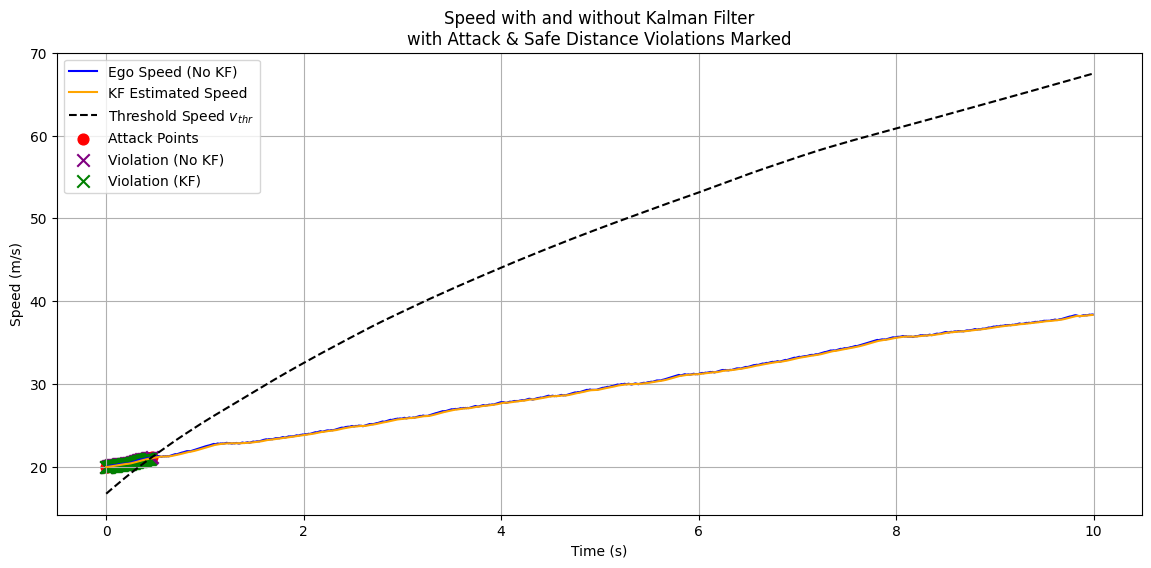

KF comparison plot generated successfully!


In [ ]:
# ================= SECOND PLOT: KF vs No KF ===================
import numpy as np
import matplotlib.pyplot as plt

# Ensure sorted
df = df.sort_values(by="timestamp").reset_index(drop=True)

time = df["timestamp"].values
vh = df["ego_vehicle_v_mps"].values
vthr = df["threshold_speed"].values

# ------------ Simple 1D Kalman Filter for Speed ----------------
Q = 0.2    # process noise
R = 4      # measurement noise

xh = vh[0]   # initial estimate
P = 1        # initial covariance

vh_kf = []

for z in vh:
    # prediction
    P = P + Q
    # update
    K = P / (P + R)
    xh = xh + K*(z - xh)
    P = (1 - K)*P
    vh_kf.append(xh)

vh_kf = np.array(vh_kf)

# ------------ Violation Condition (Paper Rule) -----------------
violation_idx = np.where(vh > vthr)[0]        # raw violation
violation_idx_kf = np.where(vh_kf > vthr)[0]  # KF violation

# ------------ Attack Points from dataset -----------------------
attack_idx = np.where(df["speed_violation"] == 1)[0]

# ================= Plot ========================================
plt.figure(figsize=(14,6))

plt.plot(time, vh, label="Ego Speed (No KF)", color="blue")
plt.plot(time, vh_kf, label="KF Estimated Speed", color="orange")
plt.plot(time, vthr, label="Threshold Speed $v_{thr}$",
         color="black", linestyle="--")

# Attack markers
plt.scatter(time[attack_idx], vh[attack_idx],
            color="red", marker="o", s=60,
            label="Attack Points")

# Safe distance violation markers (No KF)
plt.scatter(time[violation_idx], vh[violation_idx],
            marker="x", color="purple", s=80,
            label="Violation (No KF)")

# KF violation markers
plt.scatter(time[violation_idx_kf], vh_kf[violation_idx_kf],
            marker="x", color="green", s=80,
            label="Violation (KF)")

plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title("Speed with and without Kalman Filter\n"
          "with Attack & Safe Distance Violations Marked")
plt.grid(True)
plt.legend()
plt.show()

print("KF comparison plot generated successfully!")


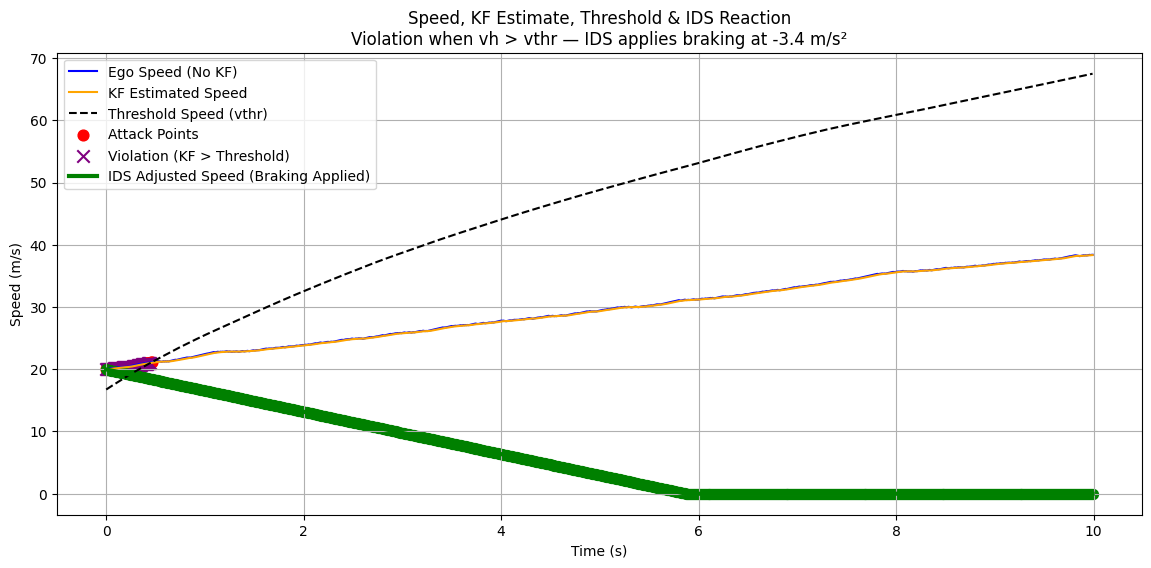

IDS + KF threshold plot generated successfully!


In [ ]:
# ================== IDS + KF + Threshold Plot ==================
import numpy as np
import matplotlib.pyplot as plt

# ensure sorted
df = df.sort_values(by="timestamp").reset_index(drop=True)

time = df["timestamp"].values
vh = df["ego_vehicle_v_mps"].values
vthr = df["threshold_speed"].values

# ================== Kalman Filter ==================
Q = 0.2
R = 4
xh = vh[0]
P = 1
vh_kf = []

for z in vh:
    P = P + Q
    K = P / (P + R)
    xh = xh + K*(z - xh)
    P = (1 - K)*P
    vh_kf.append(xh)

vh_kf = np.array(vh_kf)

# ================== Safe Distance Violations (Paper Rule) ==================
violation_idx = np.where(vh_kf > vthr)[0]

# ================== IDS Braking Logic ==================
a = -3.4   # IDS enforced braking (m/s^2)
vh_ids = vh_kf.copy()

if len(time) > 1:
    dt = np.mean(np.diff(time))
else:
    dt = 0.01

adjusted_points_t = []
adjusted_points_v = []

triggered = False

for i in range(len(time)):
    if vh_ids[i] > vthr[i]:       # IDS detects violation
        triggered = True

    if triggered:
        if i > 0:
            vh_ids[i] = max(vh_ids[i-1] + a*dt, 0)   # apply braking law
        adjusted_points_t.append(time[i])
        adjusted_points_v.append(vh_ids[i])

# ================== ATTACK MARKS ==================
attack_idx = np.where(df["speed_violation"] == 1)[0]

# ================== PLOT ==================
plt.figure(figsize=(14,6))

plt.plot(time, vh, label="Ego Speed (No KF)", color="blue")
plt.plot(time, vh_kf, label="KF Estimated Speed", color="orange")
plt.plot(time, vthr, label="Threshold Speed (vthr)",
         color="black", linestyle="--")

# Mark attacks
plt.scatter(time[attack_idx], vh[attack_idx],
            color="red", marker="o", s=60,
            label="Attack Points")

# Mark violations (when vh_kf > vthr)
plt.scatter(time[violation_idx], vh_kf[violation_idx],
            marker="x", color="purple", s=80,
            label="Violation (KF > Threshold)")

# IDS Adjusted Speed Path
if len(adjusted_points_t) > 0:
    plt.plot(adjusted_points_t, adjusted_points_v,
             color="green", linewidth=3,
             label="IDS Adjusted Speed (Braking Applied)")
    plt.scatter(adjusted_points_t, adjusted_points_v,
                color="green", s=50)

plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title(
"Speed, KF Estimate, Threshold & IDS Reaction\n"
"Violation when vh > vthr — IDS applies braking at -3.4 m/s²"
)
plt.grid(True)
plt.legend()
plt.show()

print("IDS + KF threshold plot generated successfully!")
